# A-gs model and implementation (simulation CO2 and H2O flux)

## Initialize data and model

### Setup and fetch data

In [1]:
# Settings
Username   = 'Beheerder'
years      = range(2001,2021)    #(1997,2021) # Set years to download

In [2]:
import os
datapath   = os.path.join('../../') #since this file is 2 dir down from the data it's ../../
print('datapath is set to %s'%datapath)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
#import cufflinks as cf
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
from matplotlib import cm
#from colorspacious import cspace_converter
import scipy.stats as stats
#cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)

from datetime import datetime, timedelta
import sys
sys.path.insert(0, os.path.join(datapath,'PythonScripts'))
sys.path.append('../') #append the directory above this one to path to be able to find my python modules

from Loobos_Toolbox import dateparse, dateparse_Gapfilled, Read_LoobosEddFinal, Read_LooStor, Read_LoodatGapfill, Read_Loobos_halfhourly, Read_Loobos_meteo, Read_Loobos_soil, Read_Loobos_profile

from Ags_model import runAgs, runAgs2, calc_LE

datapath is set to ../../


In [3]:
#these next two lines are to prevent re-loading the data. If you want to re-load data, instead comment them out
if not 'progress' in globals(): progress = list()
if not 'dataloaded' in progress:
  # Read files
    df_EC           = Read_LoobosEddFinal    (years,datapath)
    df_Stor         = Read_LooStor           (years,datapath)
    df_Comb         = Read_LoodatGapfill     (years,datapath)
    df_NEE          = Read_Loobos_halfhourly (years,datapath)
    df_meteo        = Read_Loobos_meteo      (years,datapath)
    df_soil         = Read_Loobos_soil       (years,datapath) 
    df_profile      = Read_Loobos_profile    (years,datapath)
    progress.append('dataloaded')

Loading 2001
Loading 2002
Loading 2003
Loading 2004
Loading 2005
Loading 2006
Loading 2007
Loading 2008
Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
Loading 2018
Loading 2019
Loading 2020
df_EC loaded. Columns in this dataframe:
Index(['Doy', 'Dtime', 'Flx_Tsonic', 'Flx_Lo-H2O', 'Flx_Lo-CO2', 'Qf_Tsonic',
       'Qf_Lo-H2O', 'Qf_Lo-CO2', 'Mea_Windsp', 'Mea_Tsonic', 'Mea_Lo-H2O',
       'Mea_Lo-CO2', 'U-star', 'Z-over-L', 'Wind-Dir', '80PercFlux'],
      dtype='object')
Loading 2001
Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2003
Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2005
Loading 2006


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2007
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009
Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014
Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2016
Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2018
Loading 2019


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2020


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_Stor loaded. Columns in this dataframe:
Index(['Day', 'Time', 'TotalT', 'TotalTflux', 'TotalH2O', 'TotalH2Oflux',
       'TotalCO2', 'TotalCO2flux', 'CO2-2.5m', 'CO2flux-2.5m'],
      dtype='object')
Loading 2001
Loading 2002
Loading 2003
Loading 2004
Loading 2005
Loading 2006
Loading 2007
Loading 2008
Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
Loading 2018
Loading 2019
Loading 2020
df_Comb loaded. Columns in this dataframe:
Index(['Year', 'DoY', 'Hour', 'qcNEE', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil',
       'rH', 'Ustar', 'VPD', 'NEE_orig', 'NEE_f', 'NEE_fqc', 'NEE_fall',
       'NEE_fall_qc', 'NEE_fnum', 'NEE_fsd', 'NEE_fmeth', 'NEE_fwin',
       'Rg_orig', 'Rg_f', 'Rg_fqc', 'Rg_fall', 'Rg_fall_qc', 'Rg_fnum',
       'Rg_fsd', 'Rg_fmeth', 'Rg_fwin', 'H_orig', 'H_f', 'H_fqc', 'H_fall',
       'H_fall_qc', 'H_fnum', 'H_fsd', 'H_fmeth', 'H_fwin', 'LE_orig', 'LE_f',
       'LE_fqc', 'LE_fall', 'LE_fall_qc', 'L

C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2003


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2005


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2006
Loading 2007


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2008
Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2010
Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2012
Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2016
Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2019


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2020


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Done
df_NEE loaded. Columns in this dataframe:
Index(['NEE_f', 'H_f', 'LE_f', 'Reco_f', 'GPP_f', 'NEE_fqc', 'H_fqc', 'LEfqc',
       'Reco', 'Tair', 'Rg_f', 'VPD', 'Tsoil', 'rH', 'Ustar', 'R-ref', 'E_0'],
      dtype='object')
Loading 2001


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2003


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2005


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2006


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2007


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2012
Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2018
Loading 2019


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser

Loading 2020
df_meteo loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'S(i)', 'S(o)', 'L(i)', 'L(o)', 'G1', 'PAR',
       'H2OLic', 'CO2Lic', '-q', 'Te(vaisal)', 'Te-L(i)', 'Te-L(o)', '-u(z)',
       '-u(dir)', 'Min u(z)', 'WSC therm', 'SD S(i)', 'SD S(o)', 'SD L(i)',
       'SD L(o)', 'SD G1', 'SD PAR', 'SD H2OLic', 'SD CO2Lic', 'SD q',
       'SD Te(vaisal)', 'Battery V', 'CR10 temp', 'P(mast)00', 'P(guter)00',
       'P(mast)05', 'P(guter)05', 'P(mast)10', 'P(guter)10', 'P(mast)15',
       'P(guter)15', 'P(mast)20', 'P(guter)20', 'P(mast)25', 'P(guter)25',
       'P(mast)', 'P(guter)', 'P(field)', 'L(i)corr', 'L(o)corr', 'R(net)',
       'P(guter)corr', 'Pcorr', 'PARrefl', 'PARdiff', 'H2Olic', 'CO2lic',
       'Vbatt', 'CR10temp', 'SD u(z)', '#NAME?', '#NAME?.1', '#NAME?.2'],
      dtype='object')
Loading ../../\Soilmoist\Final\Loosoifinal01.csv...
Loading ../../\Soilmoist\Final\Loosoifinal02.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal03.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal04.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal05.csv...
Loading ../../\Soilmoist\Final\Loosoifinal06.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal07.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal08.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal09.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal10.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal11.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal12.csv...
Loading ../../\Soilmoist\Final\Loosoifinal13.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal14.csv...
Loading ../../\Soilmoist\Final\Loosoifinal15.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal16.csv...
Loading ../../\Soilmoist\Final\Loosoifinal17.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal18.csv...
Loading ../../\Soilmoist\Final\Loosoifinal19.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../../\Soilmoist\Final\Loosoifinal20.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_soil loaded. Columns in this dataframe:
Index(['Time', 'Daynumber', 'Year', 'EC200', 'EC201', 'EC202', 'EC203',
       'EC204', 'EC205', 'EC206', 'EC207', 'EC208', 'EC209', 'Temp200',
       'Temp201', 'Temp202', 'Temp203', 'Temp204', 'Temp205', 'Temp206',
       'Temp207', 'Temp208', 'Temp209', 'Eps200co', 'Eps201co', 'Eps202co',
       'Eps203co', 'Eps204co', 'Eps205co', 'Eps206co', 'Eps207co', 'Eps208co',
       'Eps209co', 'SM-Lit', 'SM-003', 'SM-020', 'SM-050', 'SM-100', 'ST-Lit',
       'ST-003', 'ST-020', 'ST-050', 'ST-100', 'T-bole'],
      dtype='object')
Loading 2001
Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2003
Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2005


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2006
Loading 2007


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_pars

Loading 2008
Loading 2009
Loading 2010
Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2012
Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014
Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2019
Loading 2020


C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\FigurePlotting\../../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_profile loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'Vtemptop', 'Vtempmid', 'Vtempbot', 'VaiVPtop',
       'VaiVPmid', 'Pressure', 'VecWStop', 'VecWSmid', 'VecWSbot', 'H2Olevel1',
       'H2Olevel2', 'H2Olevel3', 'H2Olevel4', 'H2Olevel5', 'CO2level1',
       'CO2level2', 'CO2level3', 'CO2level4', 'CO2level5', 'H2Ocal', 'CO2cal'],
      dtype='object')


In [5]:
# Make filter for GPP orginial data and not gapfilled
#General filters
I = ((df_Comb['GPP_fqc']==0)&(df_meteo['PAR']>0))
#t = df_profile.index                                          
#time = (t < np.datetime64('2013-05-08')) | (t > np.datetime64('2013-06-01'))

# Filter for CO2 data
CO2 = (df_profile['CO2level1'] > 300)

# Filter for L(o)corr data
Locorr= (df_meteo['L(o)corr']>0) 

# Filter for VPD data
VPD = (df_Comb['VPD']>=0)

# Filter for U-star
Ustar = (df_EC['U-star']>=0)

# Combine all filters
filter = I & CO2 & Locorr & VPD & Ustar

#Column 'CO2' is input from df_profile
#df_profile_CO2 = df_profile[CO2]
#df_profile_filter = df_profile_CO2[I]
df_profile_filter = df_profile[filter]

#Column 'L(o)corr' and 'PAR' are inputs from df_meteo
#df_meteo_CO2 = df_meteo[CO2]
#df_meteo_filter = df_meteo_CO2[I]
df_meteo_filter = df_meteo[filter]

#Columns 'VPD' and 'Tair' are inputs from df_Comb
#df_Comb_CO2 = df_Comb[CO2]
#df_Comb_filter = df_Comb_CO2[I]
df_Comb_filter = df_Comb[filter]

# Columns 'Mea_Windsp' and 'U-star' are inputs from df_EC
#df_EC_CO2 = df_EC[CO2]
#df_EC_filter = df_EC_CO2[I]
df_EC_filter = df_EC[filter]

In [6]:
from FilterData import Filter_wrap
CO2,Locorr,VPD,Ustar,df_profile_filter,df_meteo_filter,df_Comb_filter,df_EC_filter=Filter_wrap(df_Comb,df_profile,df_meteo,df_EC,filterversion='default')
#NOTE: df_Stor is NOT FILTERED

In [7]:
from FilterData import Filter_GPP_LE_NEE_VPD 
df_Comb_filter2 = Filter_GPP_LE_NEE_VPD(df_Comb,fqc=None)

### Run A-gs model

In [8]:
# Run A-gs model

an_final_10,an_umol_10,rs_10, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=1.0)
#an_final_8,an_umol_8,rs_8, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.8)
#an_final_6,an_umol_6,rs_6, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.6)
#an_final_4,an_umol_4,rs_4, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.4)
#an_final_2,an_umol_2,rs_2, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.2)

#an_final_g,an_umol_g,rs_g, ra_g = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.8,gmin_input=0.01985)




## Calcuate ET

### Assemble dataframe 'df_ET' that will hold output and fill with inputs

In [9]:
def init_ETframe(rs_series):
    df_ET = pd.concat([df_meteo['L(o)'],df_meteo['Te-L(o)'],df_profile['Pressure'],df_Comb['VPD'],df_Comb['rH'],df_meteo['P(mast)']],axis=1,sort=False)
    #convert Pressure from hPa to kPa 
    df_ET['p_kPa']=df_ET['Pressure']/10
    df_ET['VPD_adj']=df_ET['VPD'].loc[df_ET['VPD']>0] #some outlier values for VPD are negative, remove from dataset
    df_ET['VPD_adj']=df_ET['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa
    df_ET['rs']=rs_series.to_frame(name="rs")
    df_ET['ra']=ra.to_frame(name="ra")
    return df_ET

In [10]:
df_ET_10=init_ETframe(rs_10)
#df_ET_8=init_ETframe(rs_8)
#df_ET_6=init_ETframe(rs_6)
#df_ET_4=init_ETframe(rs_4)
#df_ET_2=init_ETframe(rs_2)
#df_ET_g=init_ETframe(rs_g)

In [11]:
df_ET_10=calc_LE(df_ET_10)
#df_ET_8=calc_LE(df_ET_8)
#df_ET_6=calc_LE(df_ET_6)
#df_ET_4=calc_LE(df_ET_4)
#df_ET_2=calc_LE(df_ET_2)
#df_ET_g=calc_LE(df_ET_g)

In [12]:
#df_ET_10['L(o)_corr'].resample('M').mean().plot(label='mine',legend='y')
#df_meteo_filter['L(o)corr'].resample('M').mean().plot(label='dataset',legend='y')

In [27]:
df_ET_meas=df_Comb_filter.copy()
df_ET_meas=df_ET_meas.loc[df_ET_meas['LE']>=0]
#df_ET_meas=df_ET_meas.resample("1H").mean()
#df_ET_meas['LE'].plot()

In [14]:
#df_ET_1h=df_ET_10.resample('1H').mean().between_time('9:00','15:00')
#df_ET_1h

,L(o),Te-L(o),Pressure,VPD,rH,P(mast),p_kPa,VPD_adj,rs,ra,...,e_sat,q_sat,e_act_fromVPD,q_act_fromVPD,VPDq_fromVPD,e_act_fromRH,q_act_fromRH,VPDq_fromRH,ET,ET_VPD
2001-01-01 09:00:00,-0.930333,1.106500,992.000000,0.135578,97.983333,0.000000,99.200000,0.013558,NaN,NaN,...,0.590199,0.003696,0.576641,0.003611,0.000085,0.578340,0.003622,0.000074,NaN,NaN
2001-01-01 12:00:00,-2.022833,2.769167,990.333333,0.113363,98.500000,0.033333,99.033333,0.011336,NaN,NaN,...,0.654740,0.004107,0.643404,0.004036,0.000071,0.644920,0.004045,0.000062,NaN,NaN
2001-01-01 15:00:00,-2.815333,3.895167,990.500000,0.081310,99.000000,0.466667,99.050000,0.008131,NaN,NaN,...,0.701499,0.004400,0.693368,0.004349,0.000051,0.694526,0.004356,0.000044,NaN,NaN
2001-01-02 09:00:00,-4.888500,7.355167,988.000000,0.554577,94.683333,0.000000,98.800000,0.055458,NaN,NaN,...,0.871873,0.005482,0.816415,0.005133,0.000349,0.824220,0.005182,0.000300,NaN,NaN
2001-01-02 12:00:00,-4.736000,10.245000,986.833333,1.677700,86.266667,0.000000,98.683333,0.167770,NaN,NaN,...,1.066159,0.006712,0.898389,0.005655,0.001056,0.918378,0.005781,0.000930,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30 12:00:00,-0.255333,4.829667,994.833333,1.389862,83.933333,0.033333,99.483333,0.138986,NaN,NaN,...,0.778499,0.004861,0.639513,0.003993,0.000868,0.653053,0.004078,0.000783,NaN,NaN
2020-12-30 15:00:00,-1.049000,4.672833,995.666667,1.548333,82.183333,0.000000,99.566667,0.154833,NaN,NaN,...,0.761073,0.004749,0.606239,0.003782,0.000966,0.625165,0.003901,0.000848,NaN,NaN
2020-12-31 09:00:00,0.721167,2.215333,997.000000,0.881465,87.850000,0.000000,99.700000,0.088147,NaN,NaN,...,0.655683,0.004085,0.567536,0.003536,0.000549,0.576017,0.003589,0.000496,NaN,NaN
2020-12-31 12:00:00,0.593500,2.829500,997.000000,0.949440,87.283333,0.033333,99.700000,0.094944,NaN,NaN,...,0.683825,0.004261,0.588881,0.003669,0.000592,0.596852,0.003719,0.000542,NaN,NaN


In [15]:
#filter for rain
knmi_rain_daily=pd.read_csv('./knmi_rain_daily.csv')
knmi_rain_daily.index=pd.to_datetime(knmi_rain_daily['date'],format='%Y-%m-%d')
knmi_rain_daily['is_zero']=knmi_rain_daily['RD']==0.0
rain_is_zero=knmi_rain_daily.loc[:,['is_zero']]
rain_is_zero=rain_is_zero.resample('3H').ffill()
rain_is_zero_corr=rain_is_zero.copy()
rain_is_zero=rain_is_zero.between_time('9:00','15:00')
df_ET_3h=df_ET_3h.loc['2001-01-01':'2020-12-30'] #the knmi dataset is 1 day shorter
df_ET_3h=df_ET_3h.loc[rain_is_zero['is_zero']==True]
#df_ET_3h

In [15]:
#compare differnce between two datetimeindex
#C = df_ET_3h[~df_ET_3h.index.isin(rain_is_zero.index)]

### calculate ET

## Correlation plots

### CO2 flux

In [16]:
an_umol = an_umol_10

intercept = 0.432, slope = 1.194, R2 = 0.767


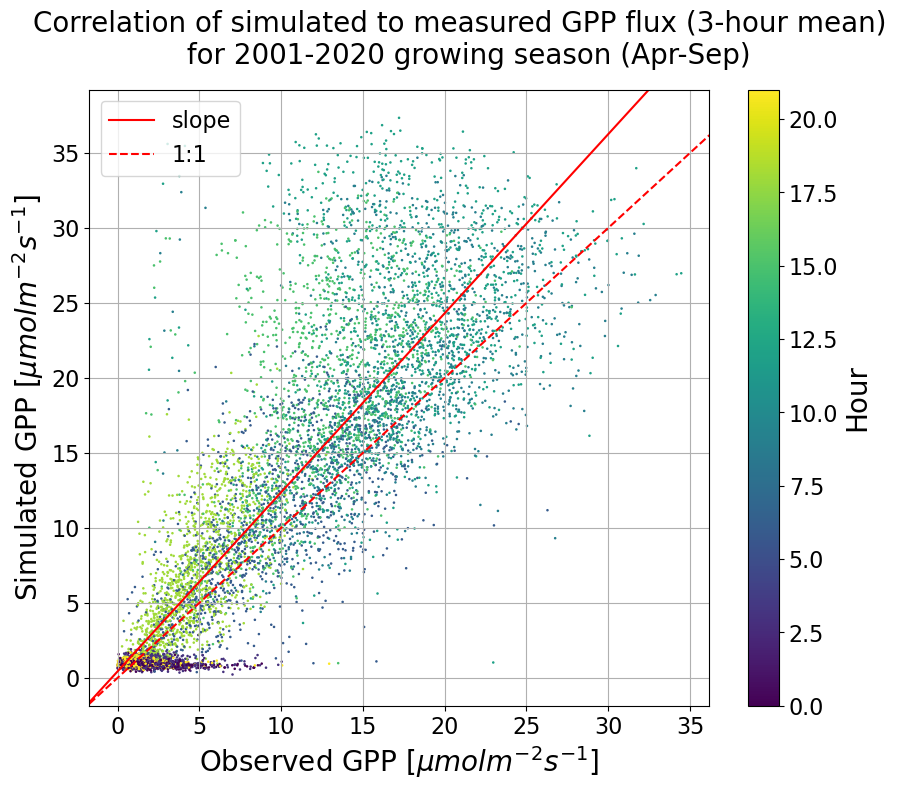

In [17]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 16})
#start='2017-05-01 00:00'
#end='2017-05-30 00:00'
start='2008-05-01 00:00'
end='2018-09-30 00:00'
sim_data=an_umol.loc[an_umol>0].loc[start:end].resample('3H').mean()#.between_time("06:00", "18:00")
sim_data = sim_data.loc[(sim_data.index.month>=4) & (sim_data.index.month<=9)]
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb['GPP_f'].loc[start:end]
measured_data=measured_data.loc[measured_data>0]
measured_data=measured_data.resample('3H').mean()#.between_time("06:00", "18:00")
measured_data=measured_data.dropna()

df_tmp = pd.DataFrame()
df_tmp['sim_data']=sim_data

df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['GPP_f'], df_tmp['sim_data'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
#print('R2: ',r_value**2)
#print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['GPP_f'],df_tmp['sim_data'],c=df_tmp.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
#ax.set_ylim(-5,40)
#ax.set_xlim(-5,40)
ax.set_xlabel(r'Observed GPP [$\mu molm^{-2}s^{-1}$]',fontsize=20)
ax.set_ylabel(r'Simulated GPP [$\mu molm^{-2}s^{-1}$]',fontsize=20)
fig.suptitle('Correlation of simulated to measured GPP flux (3-hour mean) \n for 2001-2020 growing season (Apr-Sep)',fontsize=20)
print('intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Hour',fontsize=20)
ax.grid()

intercept = 4.167, slope = 0.945, R2 = 0.489


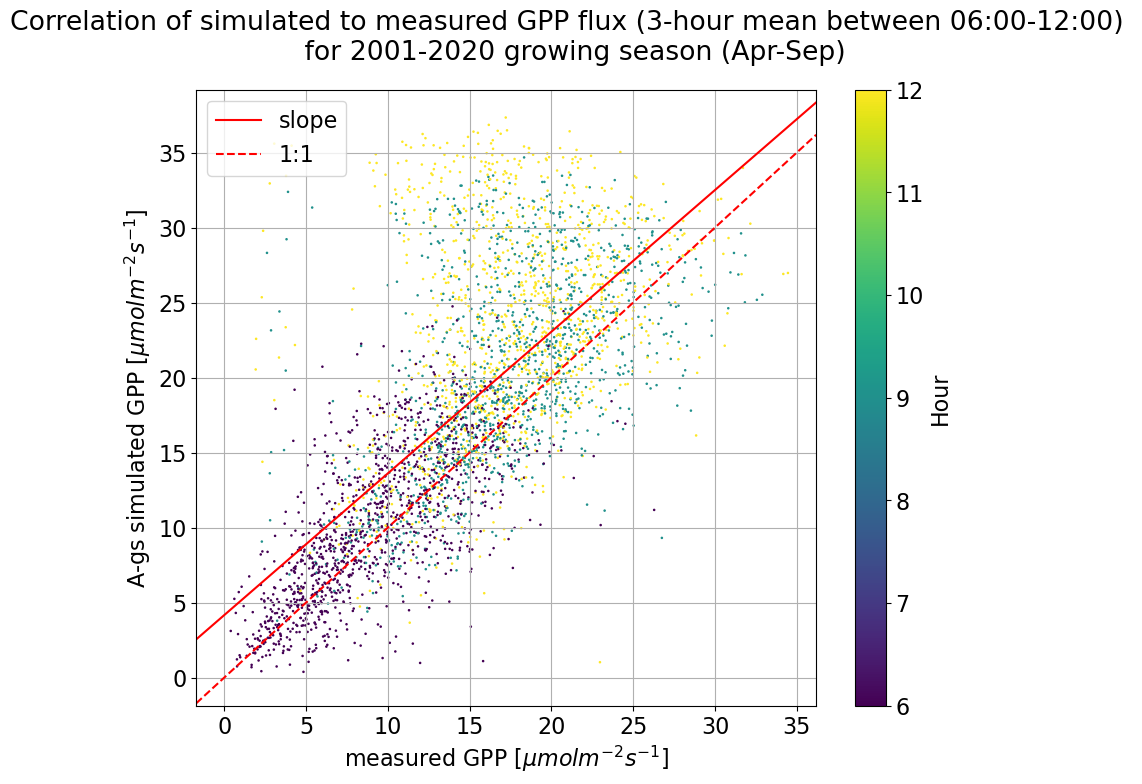

In [18]:
#start='2017-05-01 00:00'
#end='2017-05-30 00:00'
start='2008-05-01 00:00'
end='2018-09-30 00:00'
sim_data=an_umol.loc[an_umol>0].loc[start:end].resample('3H').mean().between_time("06:00", "12:00")
sim_data = sim_data.loc[(sim_data.index.month>=4) & (sim_data.index.month<=9)]
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb['GPP_f'].loc[start:end]
measured_data=measured_data.loc[measured_data>0]
measured_data=measured_data.resample('3H').mean()#.between_time("11:00", "16:00")
measured_data=measured_data.dropna()

df_tmp = pd.DataFrame()
df_tmp['sim_data']=sim_data

df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['GPP_f'], df_tmp['sim_data'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
#print('R2: ',r_value**2)
#print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['GPP_f'],df_tmp['sim_data'],c=df_tmp.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
#ax.set_ylim(-5,40)
#ax.set_xlim(-5,40)
ax.set_xlabel(r'measured GPP [$\mu molm^{-2}s^{-1}$]')
ax.set_ylabel(r'A-gs simulated GPP [$\mu molm^{-2}s^{-1}$]')
fig.suptitle('Correlation of simulated to measured GPP flux (3-hour mean between 06:00-12:00) \n for 2001-2020 growing season (Apr-Sep)')
print('intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Hour')
ax.grid()

### H2O flux

intercept = 1.266, slope = 1.766, R2 = 0.570


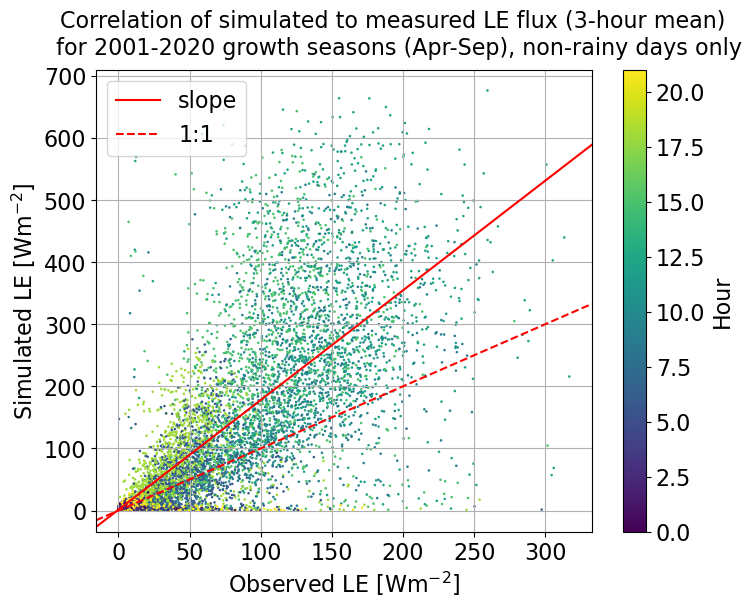

In [19]:
#re-draw better correlation plot (longer dataset)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 16})

start='2001-05-01 00:00'
end='2020-09-30 00:00'
 
#new filter
sim_data = df_ET_10.loc[start:end,['ET_VPD']]
sim_data= sim_data.resample('3H').mean()#.between_time("6:00", "9:00")
sim_data = sim_data.loc[(sim_data.index.month>=4) & (sim_data.index.month<=9)]
sim_data=sim_data.dropna()

measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean()#.between_time("6:00", "9:00")
measured_data=measured_data.dropna()
   
df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)
df_tmp=df_tmp.merge(rain_is_zero_corr['is_zero'], how='inner',left_index=True, right_index=True)
df_tmp=df_tmp.loc[df_tmp['is_zero']==True]

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
#print('R2: ',r_value**2)
#print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['LE'],df_tmp['ET_VPD'],c=df_tmp.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
#ax.set_ylim(-10,175)
#ax.set_xlim(-10,175)
ax.set_xlabel(r'Observed LE [Wm$^{-2}$]',fontsize=16)
ax.set_ylabel(r'Simulated LE [Wm$^{-2}$]',fontsize=16)
#fig.suptitle('Correlation of simulated to measured LE (3hour mean) \n for 2008-2018 during growth season (May-Oct), no rain last 3 days \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
fig.suptitle('Correlation of simulated to measured LE flux (3-hour mean) \n for 2001-2020 growth seasons (Apr-Sep), non-rainy days only',fontsize=16)
print('intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
#ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Hour',fontsize=16)
ax.grid()

intercept = 2.489, slope = 1.729, R2 = 0.440


Text(0, 0.5, 'Hour')

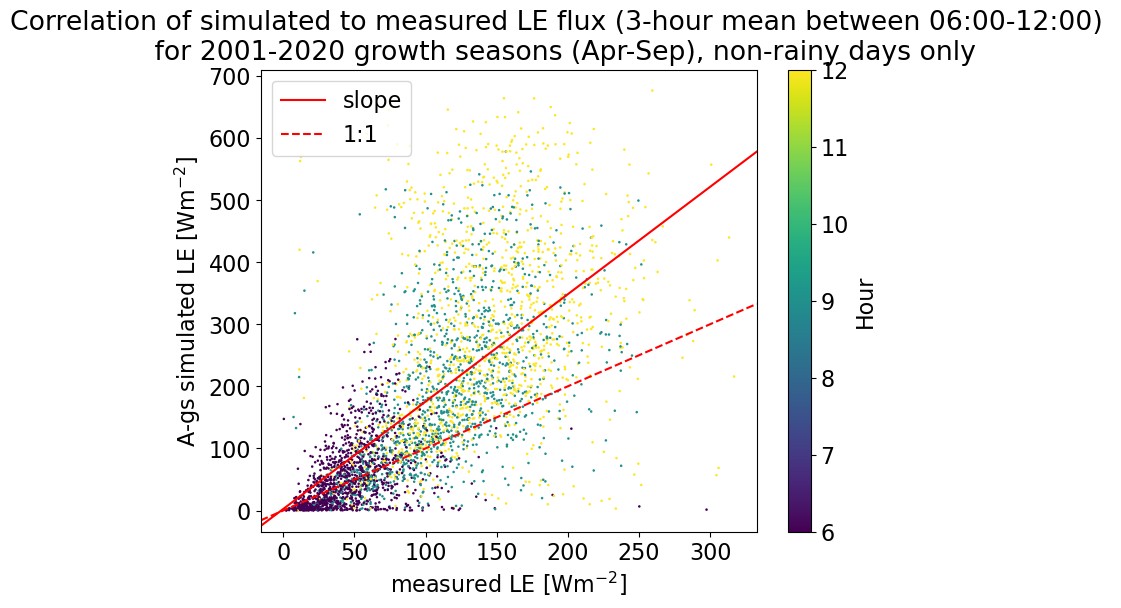

In [20]:
#re-draw better correlation plot (longer dataset)
start='2001-05-01 00:00'
end='2020-09-30 00:00'
 
#new filter
sim_data = df_ET_10.loc[start:end,['ET_VPD']]
sim_data= sim_data.resample('3H').mean().between_time("6:00", "12:00")
sim_data = sim_data.loc[(sim_data.index.month>=4) & (sim_data.index.month<=9)]
sim_data=sim_data.dropna()

measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean().between_time("6:00", "12:00")
measured_data=measured_data.dropna()
   
df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)
df_tmp=df_tmp.merge(rain_is_zero_corr['is_zero'], how='inner',left_index=True, right_index=True)
df_tmp=df_tmp.loc[df_tmp['is_zero']==True]

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
#print('R2: ',r_value**2)
#print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['LE'],df_tmp['ET_VPD'],c=df_tmp.index.hour,s=0.7,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
#ax.set_ylim(-10,175)
#ax.set_xlim(-10,175)
ax.set_xlabel(r'measured LE [Wm$^{-2}$]')
ax.set_ylabel(r'A-gs simulated LE [Wm$^{-2}$]')
#fig.suptitle('Correlation of simulated to measured LE (3hour mean) \n for 2008-2018 during growth season (May-Oct), no rain last 3 days \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
fig.suptitle('Correlation of simulated to measured LE flux (3-hour mean between 06:00-12:00) \n for 2001-2020 growth seasons (Apr-Sep), non-rainy days only')
print('intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
#ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Hour')

In [24]:
#re-draw better correlation plot (plot leaf temperature)
start='2017-04-14 00:00'
end='2017-08-30 00:00'

#new filter
sim_data = df_ET.loc[start:end,('ET_VPD','last3day_prec','T_sfc_C')]
sim_data = sim_data.loc[sim_data['last3day_prec']==0.0]
sim_data= sim_data.resample('3H').mean()
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean()
measured_data=measured_data.dropna()

#df_tmp = pd.DataFrame()
df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['LE'],df_tmp['ET_VPD'],c=df_tmp['T_sfc_C'],cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
ax.set_ylim(-10,175)
ax.set_xlim(-10,175)
ax.set_xlabel(r'measured data LE (EC) [Wm$^{-2}$]')
ax.set_ylabel(r'simulated data LE (A-gs) [Wm$^{-2}$]')
fig.suptitle('Correlation of simulated to measured LE. April-Oct 2017, (3hour mean, 00:00-23:59) \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Temp [oC]')

NameError: name 'df_ET' is not defined

## Hourly averages section (hour as bins)

     meas_avg    meas_q1    meas_q3    sim_avg     sim_q1     sim_q3
0   -0.389617  -1.556742   0.928725   0.781620   0.676634   0.875228
1    0.039371  -0.977123   1.259243   0.779753   0.681598   0.872314
2    0.095211  -1.001632   1.295890   0.781224   0.685642   0.874765
3    0.227291  -0.855328   1.346225   0.777010   0.682734   0.870858
4    0.275881  -0.866683   1.433461   0.775304   0.681630   0.872246
5    0.437626  -0.739343   1.620975   1.203235   0.732893   1.542719
6    2.563430   0.112170   4.815900   3.373643   1.127021   5.034628
7    7.828067   3.362800  11.870238   7.891005   3.945961  11.476944
8   13.214499   8.820500  17.291000  14.141047   9.524117  18.720666
9   15.898386  11.964887  19.643125  17.913750  13.442592  22.836442
10  17.408350  13.598875  21.100000  20.569105  15.503724  25.877606
11  17.768696  13.951000  21.566000  22.110547  16.973796  27.513077
12  18.156520  14.173500  21.928000  23.137057  18.131249  28.662103
13  17.321264  13.488050  21.22250

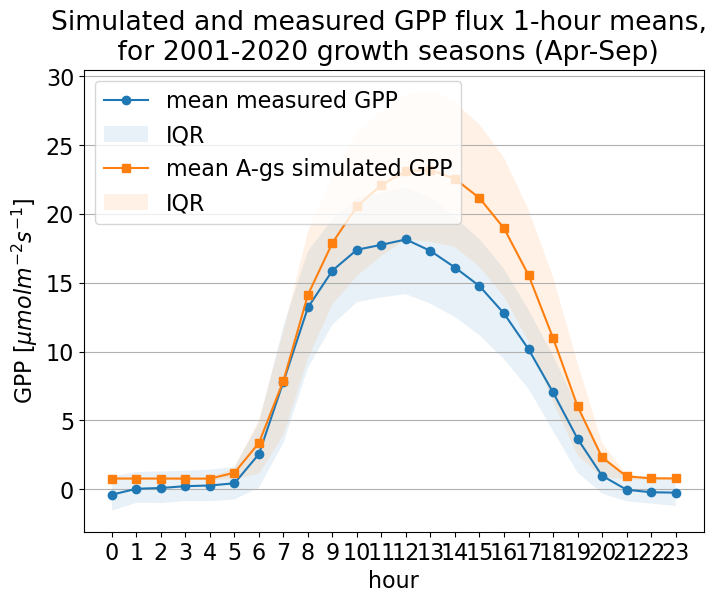

In [22]:
#draw binned GPP
start='2001-04-01 00:00'
end='2020-09-30 00:00'

an_umol=an_umol_10

sim_data=an_umol.loc[an_umol>0].loc[start:end].resample('1H').mean()#.between_time("11:00", "18:00")
sim_data = sim_data.loc[(sim_data.index.month>=4) & (sim_data.index.month<=9)]
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb['GPP_f'].loc[start:end].resample('1H').mean()#.between_time("11:00", "18:00")
measured_data=measured_data.dropna()

#new filter
#sim_data = df_ET_1.loc[start:end,('ET_VPD2','last24h_prec')]
#sim_data = sim_data.loc[sim_data['last24h_prec']<=0.5]

#df_tmp = pd.DataFrame()
df_tmp=pd.DataFrame(sim_data)
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

#slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['GPP_f'], df_tmp['sim_data'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
#print('R2: ',r_value**2)
#print('slope, intercept:', slope, intercept)

hours_list=[num for num in range(0,24)]
 
d={}
d['meas_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'GPP_f'].mean() for i in hours_list]
d['meas_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'GPP_f'].quantile(q=0.25) for i in hours_list]
d['meas_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'GPP_f'].quantile(q=0.75) for i in hours_list]
d['sim_avg'] = [df_tmp.loc[df_tmp.index.hour==i,0].mean() for i in hours_list]
d['sim_q1'] = [df_tmp.loc[df_tmp.index.hour==i,0].quantile(q=0.25) for i in hours_list]
d['sim_q3'] = [df_tmp.loc[df_tmp.index.hour==i,0].quantile(q=0.75) for i in hours_list]

df_avg=pd.DataFrame(d)

print(df_avg)

fig,ax = plt.subplots()
p1=ax.plot(df_avg['meas_avg'],marker='o',label='mean measured GPP')
ax.fill_between(hours_list,df_avg['meas_q1'],df_avg['meas_q3'],alpha=0.1,label='IQR')
p2=ax.plot(df_avg['sim_avg'],marker='s',label='mean A-gs simulated GPP')
ax.fill_between(hours_list,df_avg['sim_q1'],df_avg['sim_q3'],alpha=0.1,label='IQR')

#ax.set_ylim(-5,40)
#ax.set_xlim(-5,40)
plt.xticks(hours_list) 
ax.set_xlabel('hour')
ax.set_ylabel(r'GPP [$\mu molm^{-2}s^{-1}$]')

fig.suptitle('Simulated and measured GPP flux 1-hour means, \n for 2001-2020 growth seasons (Apr-Sep)')
ax.legend(loc='upper left')
ax.grid(axis='y')


In [44]:
# new alternate plot
df_ET_1h=df_ET_10.resample('1H').mean()
df_ET_1h=df_ET_1h.loc['2001-01-01':'2020-12-30'] #knmi dataset is 1 day longer
df_ET_1h=df_ET_1h.loc[rain_is_zero_1h['is_zero']==True]
#df_ET_1h

      meas_avg    meas_q1    meas_q3     sim_avg      sim_q1      sim_q3
0    11.526695    2.58250   13.56000    3.511670    1.174285    4.680252
1    12.018766    3.06125   12.43500    3.149046    0.980175    4.304048
2    11.391162    2.81500   12.77750    2.977266    0.900208    4.128721
3    13.004594    2.98000   13.48750    2.681178    0.728497    3.687421
4    12.343087    2.76250   12.84500    2.467346    0.609366    3.404715
5    14.031304    4.44000   15.54000    3.159689    0.575020    4.070580
6    17.795329    5.66500   22.11750    9.828741    1.339851   12.732497
7    37.166653   14.66500   51.87500   26.523949    2.869152   36.200626
8    75.205954   42.19000   97.81000   58.115681    8.852233   86.373087
9   103.977218   68.18125  130.61750  100.530757   29.551603  145.600178
10  128.267973   85.04000  161.22000  146.776941   55.770708  211.110992
11  142.484130   97.27000  178.85000  185.448219   81.598876  260.153271
12  148.731259  102.36500  184.97875  214.864518  1

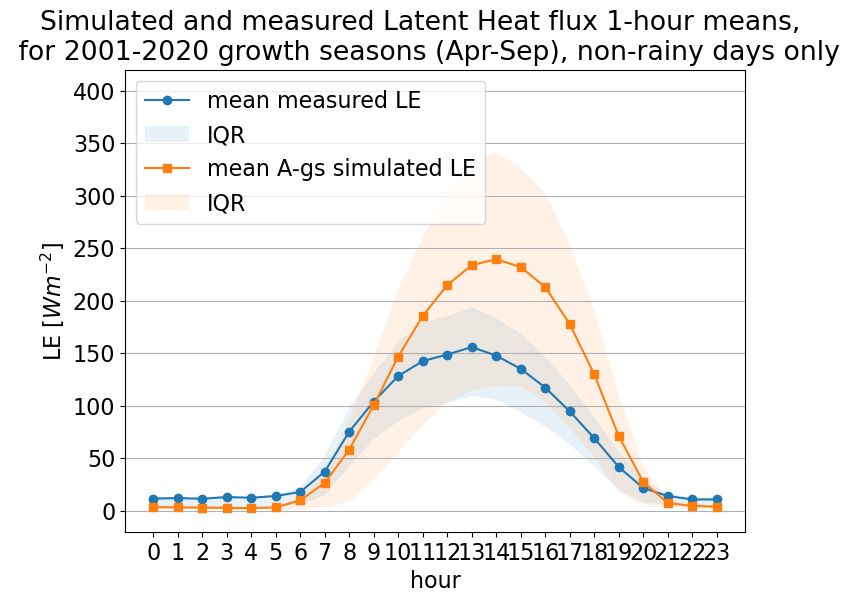

In [28]:
#draw binned LE
start='2001-04-01 00:00'
end='2020-09-30 00:00'

sim_data = df_ET_10.loc[start:end,['ET_VPD']]
sim_data = sim_data.loc[(sim_data.index.month>=4) & (sim_data.index.month<=9)]
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb_filter.loc[start:end,'LE']#.resample('1H').mean()#.between_time("11:00", "18:00")
measured_data=measured_data.loc[measured_data>0]
measured_data=measured_data.resample('1H').mean()
measured_data=measured_data.dropna()

#df_tmp = pd.DataFrame()
df_tmp=pd.DataFrame(sim_data)
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

hours_list=[num for num in range(0,24)]

d={}
d['meas_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].mean() for i in hours_list]
d['meas_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].quantile(q=0.25) for i in hours_list]
d['meas_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'LE'].quantile(q=0.75) for i in hours_list]
d['sim_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'ET_VPD'].mean() for i in hours_list]
d['sim_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'ET_VPD'].quantile(q=0.25) for i in hours_list]
d['sim_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'ET_VPD'].quantile(q=0.75) for i in hours_list]

df_avg=pd.DataFrame(d)

print(df_avg)

fig,ax = plt.subplots()
p1=ax.plot(df_avg['meas_avg'],marker='o',label='mean measured LE')
ax.fill_between(hours_list,df_avg['meas_q1'],df_avg['meas_q3'],alpha=0.1,label='IQR')
p2=ax.plot(df_avg['sim_avg'],marker='s',label='mean A-gs simulated LE')
ax.fill_between(hours_list,df_avg['sim_q1'],df_avg['sim_q3'],alpha=0.1,label='IQR')

ax.set_ylim(-20,420)
#ax.set_xlim(-5,40)
plt.xticks(hours_list) 
ax.set_xlabel('hour')
ax.set_ylabel(r'LE [$Wm^{-2}$]')
fig.suptitle('Simulated and measured Latent Heat flux 1-hour means, \n for 2001-2020 growth seasons (Apr-Sep), non-rainy days only')
ax.legend(loc='upper left')
ax.grid(axis='y')


### PAR plot by hour

In [58]:
df_meteo['PAR']

2001-01-01 00:00:00      NaN
2001-01-01 00:30:00    0.000
2001-01-01 01:00:00    0.000
2001-01-01 01:30:00    0.000
2001-01-01 02:00:00    0.000
                       ...  
2020-12-31 21:30:00    4.914
2020-12-31 22:00:00    4.959
2020-12-31 22:30:00    5.026
2020-12-31 23:00:00    5.096
2020-12-31 23:30:00    5.018
Name: PAR, Length: 350640, dtype: float64

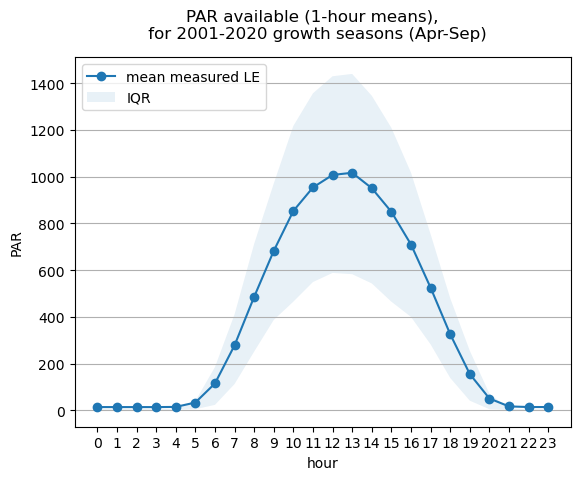

In [61]:
#draw binned LE
start='2001-04-01 00:00'
end='2020-09-30 00:00'

par_data = df_meteo.loc[start:end,['PAR']]
par_data = par_data.resample('1H').mean()
par_data = par_data.loc[(par_data.index.month>=4) & (par_data.index.month<=9)]
par_data=par_data.dropna() #eliminate NaN entries created by the .loc slice


hours_list=[num for num in range(0,24)]

d={}
d['meas_avg'] = [par_data.loc[par_data.index.hour==i,'PAR'].mean() for i in hours_list]
d['meas_q1'] = [par_data.loc[par_data.index.hour==i,'PAR'].quantile(q=0.25) for i in hours_list]
d['meas_q3'] = [par_data.loc[par_data.index.hour==i,'PAR'].quantile(q=0.75) for i in hours_list]

df_avg=pd.DataFrame(d)

fig,ax = plt.subplots()
p1=ax.plot(df_avg['meas_avg'],marker='o',label='mean measured LE')
ax.fill_between(hours_list,df_avg['meas_q1'],df_avg['meas_q3'],alpha=0.1,label='IQR')

#ax.set_ylim(-20,420)
#ax.set_xlim(-5,40)
plt.xticks(hours_list) 
ax.set_xlabel('hour')
ax.set_ylabel(r'PAR')
fig.suptitle('PAR available (1-hour means), \n for 2001-2020 growth seasons (Apr-Sep)')
ax.legend(loc='upper left')
ax.grid(axis='y')
